In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model

In [2]:
digits = np.loadtxt('ProjectDigits_materials/mfeat-pix.txt', usecols=range(240))

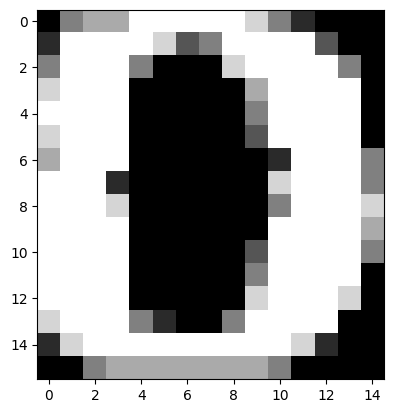

In [3]:
plt.imshow(digits[0].reshape(16,15), cmap='gray')

In [4]:
x_train = np.empty([1000, 240])
y_train = []
x_test = np.empty([1000, 240])
y_test = []
for d in range(10):
    for i in range(100):
        x_train[d*100 + i] = digits[d*200 + i]
        x_test[d*100 + i] = digits[100 + d*200 + i]
    y_train = np.concatenate((y_train, np.full(100, d)))
    y_test = np.concatenate((y_test, np.full(100, d)))

x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [5]:
lr = sklearn.linear_model.LogisticRegression(solver='saga', tol=0.1)
lr = lr.fit(x_train, y_train)

print(f'train: {lr.score(x_train, y_train)}')
print(f'test: {lr.score(x_test, y_test)}')

train: 0.981
test: 0.954
